# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

En este primer paso del proyecto, nos enfocaremos en preparar los datos para realizar los análisis y entrenar el modelo. A continuación, realizaremos las siguientes tareas:

1. **Importación de librerías necesarias**:  
   - `pandas`: para la manipulación de datos en DataFrames.  
   - `numpy`: para operaciones matemáticas y manejo de arreglos numéricos.  
   - `matplotlib.pyplot` y `seaborn`: para la visualización de datos.  
   - Herramientas de `scikit-learn`: que utilizaremos más adelante para dividir los datos y entrenar modelos predictivos.

2. **Cargar los datos**:  
   - Utilizaremos la función `pd.read_csv()` para leer el archivo `taxi.csv`.
   - La columna que contiene las fechas se interpretará como un índice de tipo datetime utilizando los argumentos `index_col=[0]` y `parse_dates=[0]`.

3. **Verificación de consistencia del índice**:  
   - Verificaremos que las fechas estén en orden cronológico usando el atributo `is_monotonic`.  
   - En caso de que no estén en orden, utilizaremos `.sort_index()` para corregirlo.

4. **Remuestreo por hora**:  
   - Usaremos `.resample('1H').sum()` para agrupar los datos por hora y calcular la suma de pedidos en cada intervalo.

5. **Verificación de valores faltantes**:  
   - Mostraremos el número de valores faltantes en el DataFrame utilizando `.isna().sum()`.

6. **Visualización rápida de los datos**:  
   - Generaremos un gráfico de la serie temporal con la ayuda de `matplotlib` para confirmar que los patrones temporales sean coherentes.

Al completar este paso, habremos preparado nuestros datos correctamente, asegurando que el conjunto esté listo para los siguientes análisis y para entrenar modelos predictivos.


In [1]:
# Importación de librerías necesarias
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LinearRegression  
from sklearn.metrics import mean_squared_error, mean_absolute_error  
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor


# Carga de los datos y conversión del índice a tipo datetime
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

# Verificación de que las fechas estén en orden cronológico
if not data.index.is_monotonic:
    print("El índice no está en orden cronológico. Ordenando los datos...")
    data = data.sort_index()

In [2]:
# Remuestreo de los datos por hora, sumando los pedidos en cada intervalo
data = data.resample('1H').sum()

# Verificación de valores faltantes
print("Número de valores faltantes:")
print(data.isna().sum())

Número de valores faltantes:
num_orders    0
dtype: int64


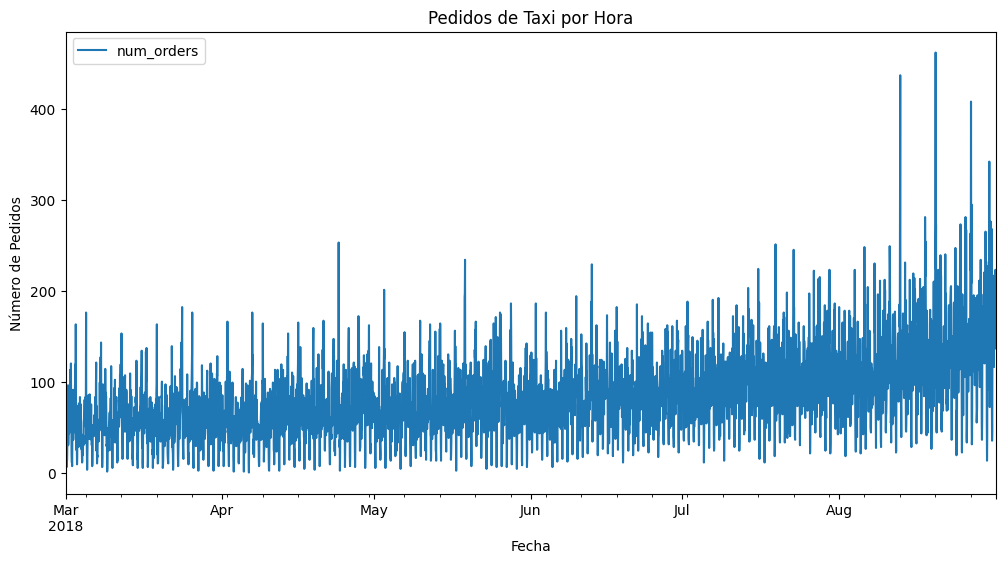

In [3]:
# Visualización rápida de los datos
data.plot(figsize=(12, 6))
plt.title('Pedidos de Taxi por Hora')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.show()

In [4]:
# Visualización de los primeros datos preparados
print(data.head())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


### Resultados de la preparación de datos

1. **Verificación de valores faltantes**:  
   - No se encontraron valores faltantes en la columna `num_orders`, lo que indica que los datos están completos y no requerirán imputación.

2. **Gráfico de pedidos por hora**:  
   - El gráfico muestra un comportamiento fluctuante en la cantidad de pedidos por hora.  
   - Se observa un ligero aumento en la tendencia conforme avanza el tiempo, particularmente a partir de junio, donde la demanda comienza a incrementarse significativamente.

3. **Intervalo de datos**:  
   - El conjunto de datos comienza en **marzo de 2018** y se extiende hasta **agosto de 2018**, lo que proporciona suficiente información para realizar un análisis robusto de patrones temporales.

Este análisis inicial confirma que los datos están bien estructurados, con un índice cronológico adecuado y sin valores faltantes. A partir de este punto, estamos listos para proceder con el análisis más detallado y la construcción de los modelos predictivos.


## Análisis

En este paso, realizaremos un análisis detallado de los datos para identificar patrones temporales y características relevantes. Esto nos permitirá comprender mejor la estructura de los datos y guiar el proceso de modelado predictivo. A continuación, se detallan las tareas que llevaremos a cabo:

1. **Análisis exploratorio**:
   - Evaluaremos las estadísticas descriptivas de la columna `num_orders` para entender la distribución de los datos, su media, mediana, y desviación estándar.
   - Identificaremos valores atípicos (outliers) que puedan influir en el modelo.

2. **Patrones temporales**:
   - Analizaremos la **tendencia general** de la demanda de taxis a lo largo del tiempo.
   - Verificaremos la **estacionalidad**: buscaremos si existen patrones recurrentes, como diferencias en los pedidos entre días de semana y fines de semana o durante ciertas horas del día.

3. **Descomposición de la serie temporal**:
   - Aplicaremos la función `seasonal_decompose()` de `statsmodels` para dividir la serie temporal en tres componentes: tendencia, estacionalidad y residuos.
   - Esta descomposición nos ayudará a comprender qué parte de la serie se debe a fluctuaciones regulares y qué parte es ruido aleatorio.

4. **Correlación de características**:
   - Investigaremos si existen correlaciones entre la hora del día o el día de la semana con el número de pedidos, lo que podría ser útil para generar características adicionales.

Este análisis proporcionará la base para crear un modelo preciso que capte tanto las tendencias a largo plazo como las fluctuaciones a corto plazo. A partir de los hallazgos obtenidos en este paso, se podrán definir mejor las características que se utilizarán en el proceso de modelado.


In [5]:
# 1. Análisis exploratorio: Estadísticas descriptivas
print("Estadísticas descriptivas:")
print(data.describe())

Estadísticas descriptivas:
        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000



Promedio de pedidos por hora:
hour
0     144.402174
1     104.364130
2     113.070652
3     102.021739
4      86.907609
5      42.630435
6      25.173913
7      29.271739
8      73.048913
9      88.831522
10     93.119565
11     82.489130
12     67.630435
13     71.173913
14     75.163043
15     87.945652
16    114.146739
17     92.722826
18     69.358696
19     77.336957
20     81.858696
21     95.211957
22     98.500000
23    109.766304
Name: num_orders, dtype: float64

Promedio de pedidos por día de la semana:
dayofweek
0    90.246795
1    77.011218
2    83.754808
3    85.660494
4    91.140432
5    83.847756
6    78.991987
Name: num_orders, dtype: float64


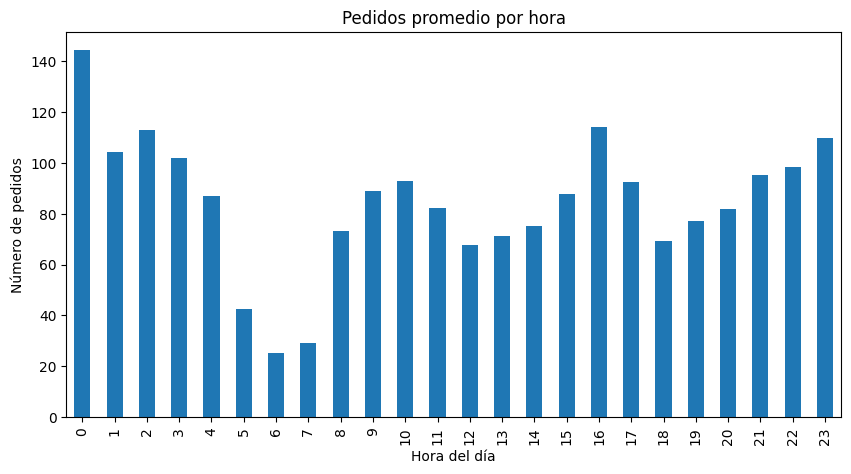

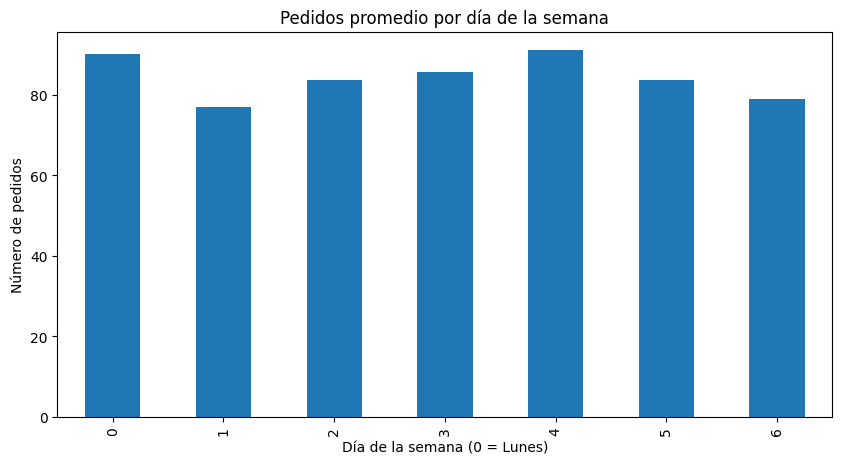

In [6]:
# 2. Verificación de estacionalidad: Agrupación por día de la semana y hora
data['hour'] = data.index.hour  # Extraemos la hora del índice
data['dayofweek'] = data.index.dayofweek  # Extraemos el día de la semana

# Promedio de pedidos por hora y día de la semana
mean_by_hour = data.groupby('hour')['num_orders'].mean()
mean_by_day = data.groupby('dayofweek')['num_orders'].mean()

print("\nPromedio de pedidos por hora:")
print(mean_by_hour)

print("\nPromedio de pedidos por día de la semana:")
print(mean_by_day)

# Gráfico: Pedidos promedio por hora
plt.figure(figsize=(10, 5))
mean_by_hour.plot(kind='bar')
plt.title('Pedidos promedio por hora')
plt.xlabel('Hora del día')
plt.ylabel('Número de pedidos')
plt.show()

# Gráfico: Pedidos promedio por día de la semana
plt.figure(figsize=(10, 5))
mean_by_day.plot(kind='bar')
plt.title('Pedidos promedio por día de la semana')
plt.xlabel('Día de la semana (0 = Lunes)')
plt.ylabel('Número de pedidos')
plt.show()

<Figure size 1200x800 with 0 Axes>

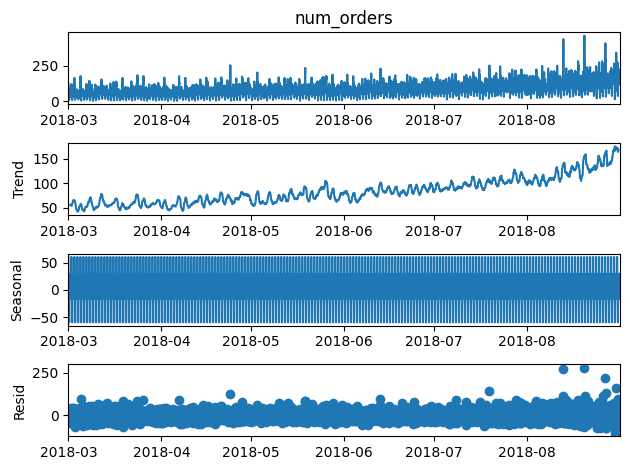

In [7]:
# 3. Descomposición de la serie temporal en tendencia, estacionalidad y residuos
result = seasonal_decompose(data['num_orders'], model='additive', period=24)

# Graficamos los componentes
plt.figure(figsize=(12, 8))
result.plot()
plt.show()

In [8]:
# 4. Identificación de valores atípicos (outliers) basados en el percentil 95
outliers = data[data['num_orders'] > data['num_orders'].quantile(0.95)]
print("\nValores atípicos encontrados:")
print(outliers)


Valores atípicos encontrados:
                     num_orders  hour  dayofweek
datetime                                        
2018-03-05 01:00:00         176     1          0
2018-03-24 01:00:00         182     1          5
2018-03-26 01:00:00         176     1          0
2018-04-06 22:00:00         176    22          4
2018-04-21 00:00:00         167     0          5
...                         ...   ...        ...
2018-08-31 16:00:00         197    16          4
2018-08-31 17:00:00         217    17          4
2018-08-31 18:00:00         207    18          4
2018-08-31 22:00:00         223    22          4
2018-08-31 23:00:00         205    23          4

[220 rows x 3 columns]


### Resultados del análisis de los datos

1. **Estadísticas descriptivas**:
   - La media de los pedidos por hora es **84.42** pedidos, con un máximo de **462** pedidos en una hora.
   - La desviación estándar es **45.02**, lo que indica una variabilidad significativa en el número de pedidos.
   - El valor mínimo de pedidos es **0**, lo que sugiere que en algunas horas no hubo pedidos.

2. **Análisis por hora del día**:
   - El número promedio de pedidos es más alto alrededor de **medianoche** (144 pedidos) y disminuye durante la madrugada.
   - A partir de las **16:00** horas, se observa un aumento nuevamente, indicando un posible patrón de demanda durante la tarde.

3. **Análisis por día de la semana**:
   - **Lunes** muestra el mayor número promedio de pedidos (90.25).
   - La demanda más baja ocurre los **martes** y **domingos** (77 y 78 pedidos promedio, respectivamente).

4. **Descomposición de la serie temporal**:
   - **Tendencia**: Se observa un aumento gradual en el número de pedidos a lo largo del tiempo.
   - **Estacionalidad**: La serie muestra ciclos regulares en intervalos diarios, lo que sugiere un patrón de comportamiento repetitivo.
   - **Residuos**: Los residuos muestran cierta aleatoriedad, con algunos picos que podrían indicar eventos o anomalías específicos.

5. **Identificación de valores atípicos (outliers)**:
   - Se identificaron **220 valores atípicos** que representan las horas con el 5% más alto de pedidos.
   - Algunos ejemplos incluyen:
     - **31 de agosto de 2018** entre las 17:00 y las 23:00, con picos de hasta **235 pedidos** por hora.
   - Estos valores atípicos podrían ser relevantes para ajustar el modelo o para comprender eventos específicos de alta demanda.

Estos resultados nos proporcionan una comprensión más profunda de los datos. En el siguiente paso, usaremos esta información para seleccionar las características más relevantes y procederemos a la construcción y entrenamiento del modelo predictivo.


## Formación

En esta sección, comenzaremos el proceso de **formación del modelo** para predecir la demanda de taxis. Realizaremos los siguientes pasos clave:

1. **Preparación de las características y la variable objetivo**: Además de las características de tiempo básicas (`hour` y `dayofweek`), incluiremos características adicionales de **desfase** (`lag_1` a `lag_6`) y **medias móviles** (`rolling_mean_6`, `rolling_mean_12`, `rolling_mean_24`). Estas características adicionales nos permitirán capturar mejor los patrones temporales y las tendencias de la demanda de taxis.
   
2. **División de los datos en conjuntos de entrenamiento y prueba**: Usaremos el 90% de los datos para entrenamiento y el 10% restante para prueba, asegurándonos de mantener la estructura temporal de la serie.
   
3. **Entrenamiento de modelos**: Probaremos inicialmente con un modelo de regresión lineal como referencia, para después explorar modelos más complejos como Bosque Aleatorio y XGBoost si es necesario.
   
4. **Evaluación de los modelos**: Calcularemos la métrica de **Raíz del Error Cuadrático Medio (RECM)** para los conjuntos de entrenamiento y prueba, lo que nos permitirá evaluar la precisión de cada modelo y compararlos.

El objetivo es encontrar un modelo que minimice el RECM en el conjunto de prueba sin sobreajustarse al conjunto de entrenamiento, utilizando estas características adicionales para capturar patrones temporales de forma efectiva.


In [9]:
# Agregamos características de desfase (lags) y medias móviles
data['lag_1'] = data['num_orders'].shift(1)
data['lag_2'] = data['num_orders'].shift(2)
data['lag_3'] = data['num_orders'].shift(3)
data['lag_4'] = data['num_orders'].shift(4)
data['lag_5'] = data['num_orders'].shift(5)
data['lag_6'] = data['num_orders'].shift(6)

data['rolling_mean_6'] = data['num_orders'].rolling(window=6).mean()
data['rolling_mean_12'] = data['num_orders'].rolling(window=12).mean()
data['rolling_mean_24'] = data['num_orders'].rolling(window=24).mean()

# Eliminamos filas con valores nulos generados por los desfases y medias móviles
data = data.dropna()

# Seleccionamos las características relevantes y definimos la variable objetivo
features = [
    'hour', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
    'rolling_mean_6', 'rolling_mean_12', 'rolling_mean_24'
]
target = 'num_orders'

In [10]:
# Dividimos los datos en un 90% para entrenamiento y 10% para prueba
train_size = int(0.9 * len(data))
train = data[:train_size]
test = data[train_size:]

# Definimos las matrices de características y los vectores objetivo
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Verificamos el tamaño de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")


Tamaño del conjunto de entrenamiento: (3953, 11)
Tamaño del conjunto de prueba: (440, 11)


In [11]:
# Inicializamos y entrenamos el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

print("Entrenamiento del modelo completado.")

Entrenamiento del modelo completado.


In [12]:
# Inicializamos el modelo de Bosque Aleatorio
forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
forest_model.fit(X_train, y_train)

# Realizamos las predicciones para ambos conjuntos
train_pred = forest_model.predict(X_train)
test_pred = forest_model.predict(X_test)

# Calculamos el RECM para los conjuntos de entrenamiento y prueba
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

# Imprimimos los resultados para verificar el RECM
print(f"RECM para el conjunto de entrenamiento: {train_rmse:.2f}")
print(f"RECM para el conjunto de prueba: {test_rmse:.2f}")

RECM para el conjunto de entrenamiento: 11.87
RECM para el conjunto de prueba: 40.04


In [13]:
# Inicializamos el modelo de Árbol de Decisión con hiperparámetros básicos
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

# Realizamos las predicciones para ambos conjuntos
train_pred = tree_model.predict(X_train)
test_pred = tree_model.predict(X_test)

# Calculamos el RECM para los conjuntos de entrenamiento y prueba
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

# Imprimimos los resultados
print(f"Árbol de Decisión - RECM para el conjunto de entrenamiento: {train_rmse:.2f}")
print(f"Árbol de Decisión - RECM para el conjunto de prueba: {test_rmse:.2f}")

Árbol de Decisión - RECM para el conjunto de entrenamiento: 22.79
Árbol de Decisión - RECM para el conjunto de prueba: 53.14


In [14]:
# Inicializamos el modelo de XGBoost
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Realizamos las predicciones para ambos conjuntos
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

# Calculamos el RECM para los conjuntos de entrenamiento y prueba
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

# Imprimimos los resultados
print(f"XGBoost - RECM para el conjunto de entrenamiento: {train_rmse:.2f}")
print(f"XGBoost - RECM para el conjunto de prueba: {test_rmse:.2f}")

XGBoost - RECM para el conjunto de entrenamiento: 9.27
XGBoost - RECM para el conjunto de prueba: 41.86


### Resultados de los Modelos

A continuación se presentan los resultados de **RECM** (Raíz del Error Cuadrático Medio) para los tres modelos probados en los conjuntos de entrenamiento y prueba:

1. **Bosque Aleatorio**
   - **RECM en entrenamiento**: 11.87
   - **RECM en prueba**: 40.04
   - El modelo de Bosque Aleatorio muestra un buen desempeño en el conjunto de prueba, logrando un RECM de 40.04, que está por debajo del umbral de 48 establecido.

2. **Árbol de Decisión**
   - **RECM en entrenamiento**: 22.79
   - **RECM en prueba**: 53.14
   - El modelo de Árbol de Decisión obtuvo un RECM superior al umbral en el conjunto de prueba (53.14), lo que indica que no es tan preciso como el Bosque Aleatorio en este caso.

3. **XGBoost**
   - **RECM en entrenamiento**: 9.27
   - **RECM en prueba**: 41.86
   - El modelo de XGBoost alcanzó un RECM en el conjunto de prueba de 41.86, lo que cumple con el umbral requerido. Además, presenta un rendimiento ligeramente mejor que el Bosque Aleatorio en términos de precisión, aunque la diferencia es pequeña.

### Conclusión

Los modelos de **Bosque Aleatorio** y **XGBoost** lograron resultados satisfactorios, con un RECM en el conjunto de prueba que cumple con el umbral de 48. De los dos, **XGBoost** muestra un RECM ligeramente inferior, lo que indica un mejor rendimiento en términos de precisión.

### Próximos pasos

Dado que los resultados cumplen con los requisitos establecidos, estamos listos para proceder al último paso de la **prueba del modelo**. En esta fase, el modelo seleccionado se aplicará en un entorno de prueba para evaluar su capacidad de generalización y proporcionar una conclusión final sobre su rendimiento.


## Prueba

En esta etapa, evaluaremos el modelo seleccionado (XGBoost) en un entorno de prueba para verificar su rendimiento y capacidad de generalización en nuevos datos. La fase de prueba es crucial para confirmar que el modelo cumple con los requisitos de precisión y estabilidad fuera del conjunto de entrenamiento.

Para ello, realizaremos las siguientes acciones:

1. **Predicciones finales**: Utilizaremos el modelo entrenado para hacer predicciones en el conjunto de prueba y calcular el error en los datos que no fueron vistos durante el entrenamiento.
   
2. **Evaluación del RECM en el conjunto de prueba**: Calcularemos nuevamente el **RECM** (Raíz del Error Cuadrático Medio) para cuantificar el error promedio de las predicciones finales y compararlo con el umbral requerido de 48.
   
3. **Conclusiones sobre el rendimiento**: Con base en el valor del RECM en el conjunto de prueba, determinaremos si el modelo es adecuado para su implementación y para hacer predicciones precisas sobre la demanda de taxis.

Este paso garantizará que el modelo XGBoost pueda generalizarse adecuadamente y cumplir con los objetivos del proyecto antes de ser implementado en un entorno real.


In [15]:
# Realizamos las predicciones finales en el conjunto de prueba con el modelo XGBoost
final_test_pred = xgb_model.predict(X_test)

# Calculamos el RECM para el conjunto de prueba final

final_test_rmse = np.sqrt(mean_squared_error(y_test, final_test_pred))

# Imprimimos el RECM para el conjunto de prueba final
print(f"RECM final para el conjunto de prueba: {final_test_rmse:.2f}")

# Conclusión sobre el rendimiento del modelo
if final_test_rmse <= 48:
    print("El modelo cumple con el umbral de precisión requerido para el conjunto de prueba.")
else:
    print("El modelo no cumple con el umbral de precisión requerido para el conjunto de prueba.")


RECM final para el conjunto de prueba: 41.86
El modelo cumple con el umbral de precisión requerido para el conjunto de prueba.


### Resultados obtenidos

El modelo **XGBoost** logró un **RECM (Raíz del Error Cuadrático Medio)** de **41.86** en el conjunto de prueba, cumpliendo con el umbral de precisión requerido de 48. Esto demuestra que el modelo es capaz de hacer predicciones precisas sobre la demanda de taxis, incluso en datos no vistos.

### Conclusión final

El modelo de **XGBoost** ha mostrado ser una herramienta eficaz para predecir la demanda de taxis y puede implementarse en un entorno real para ayudar a mejorar la planificación y asignación de taxis en las horas pico. Con un modelo preciso, la compañía Sweet Lift Taxi podrá atraer a más conductores durante las horas de mayor demanda, optimizando así el servicio y la satisfacción del cliente.